In [3]:
# coding: utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


# In[34]:

'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    return np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)*sciconsts.G/np.power(sciconsts.c,2.0)
    return np.sqrt(sciconsts.G)/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(sciconsts.G*M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70


In [4]:
#raw test

In [5]:
Ng=10000
t_scale=100.0 
Tg=t_scale/Ng
t=np.linspace(0,t_scale,Ng)
h1=np.sin(20*sciconsts.pi*t)
h2=5*np.sin(15*sciconsts.pi*t)

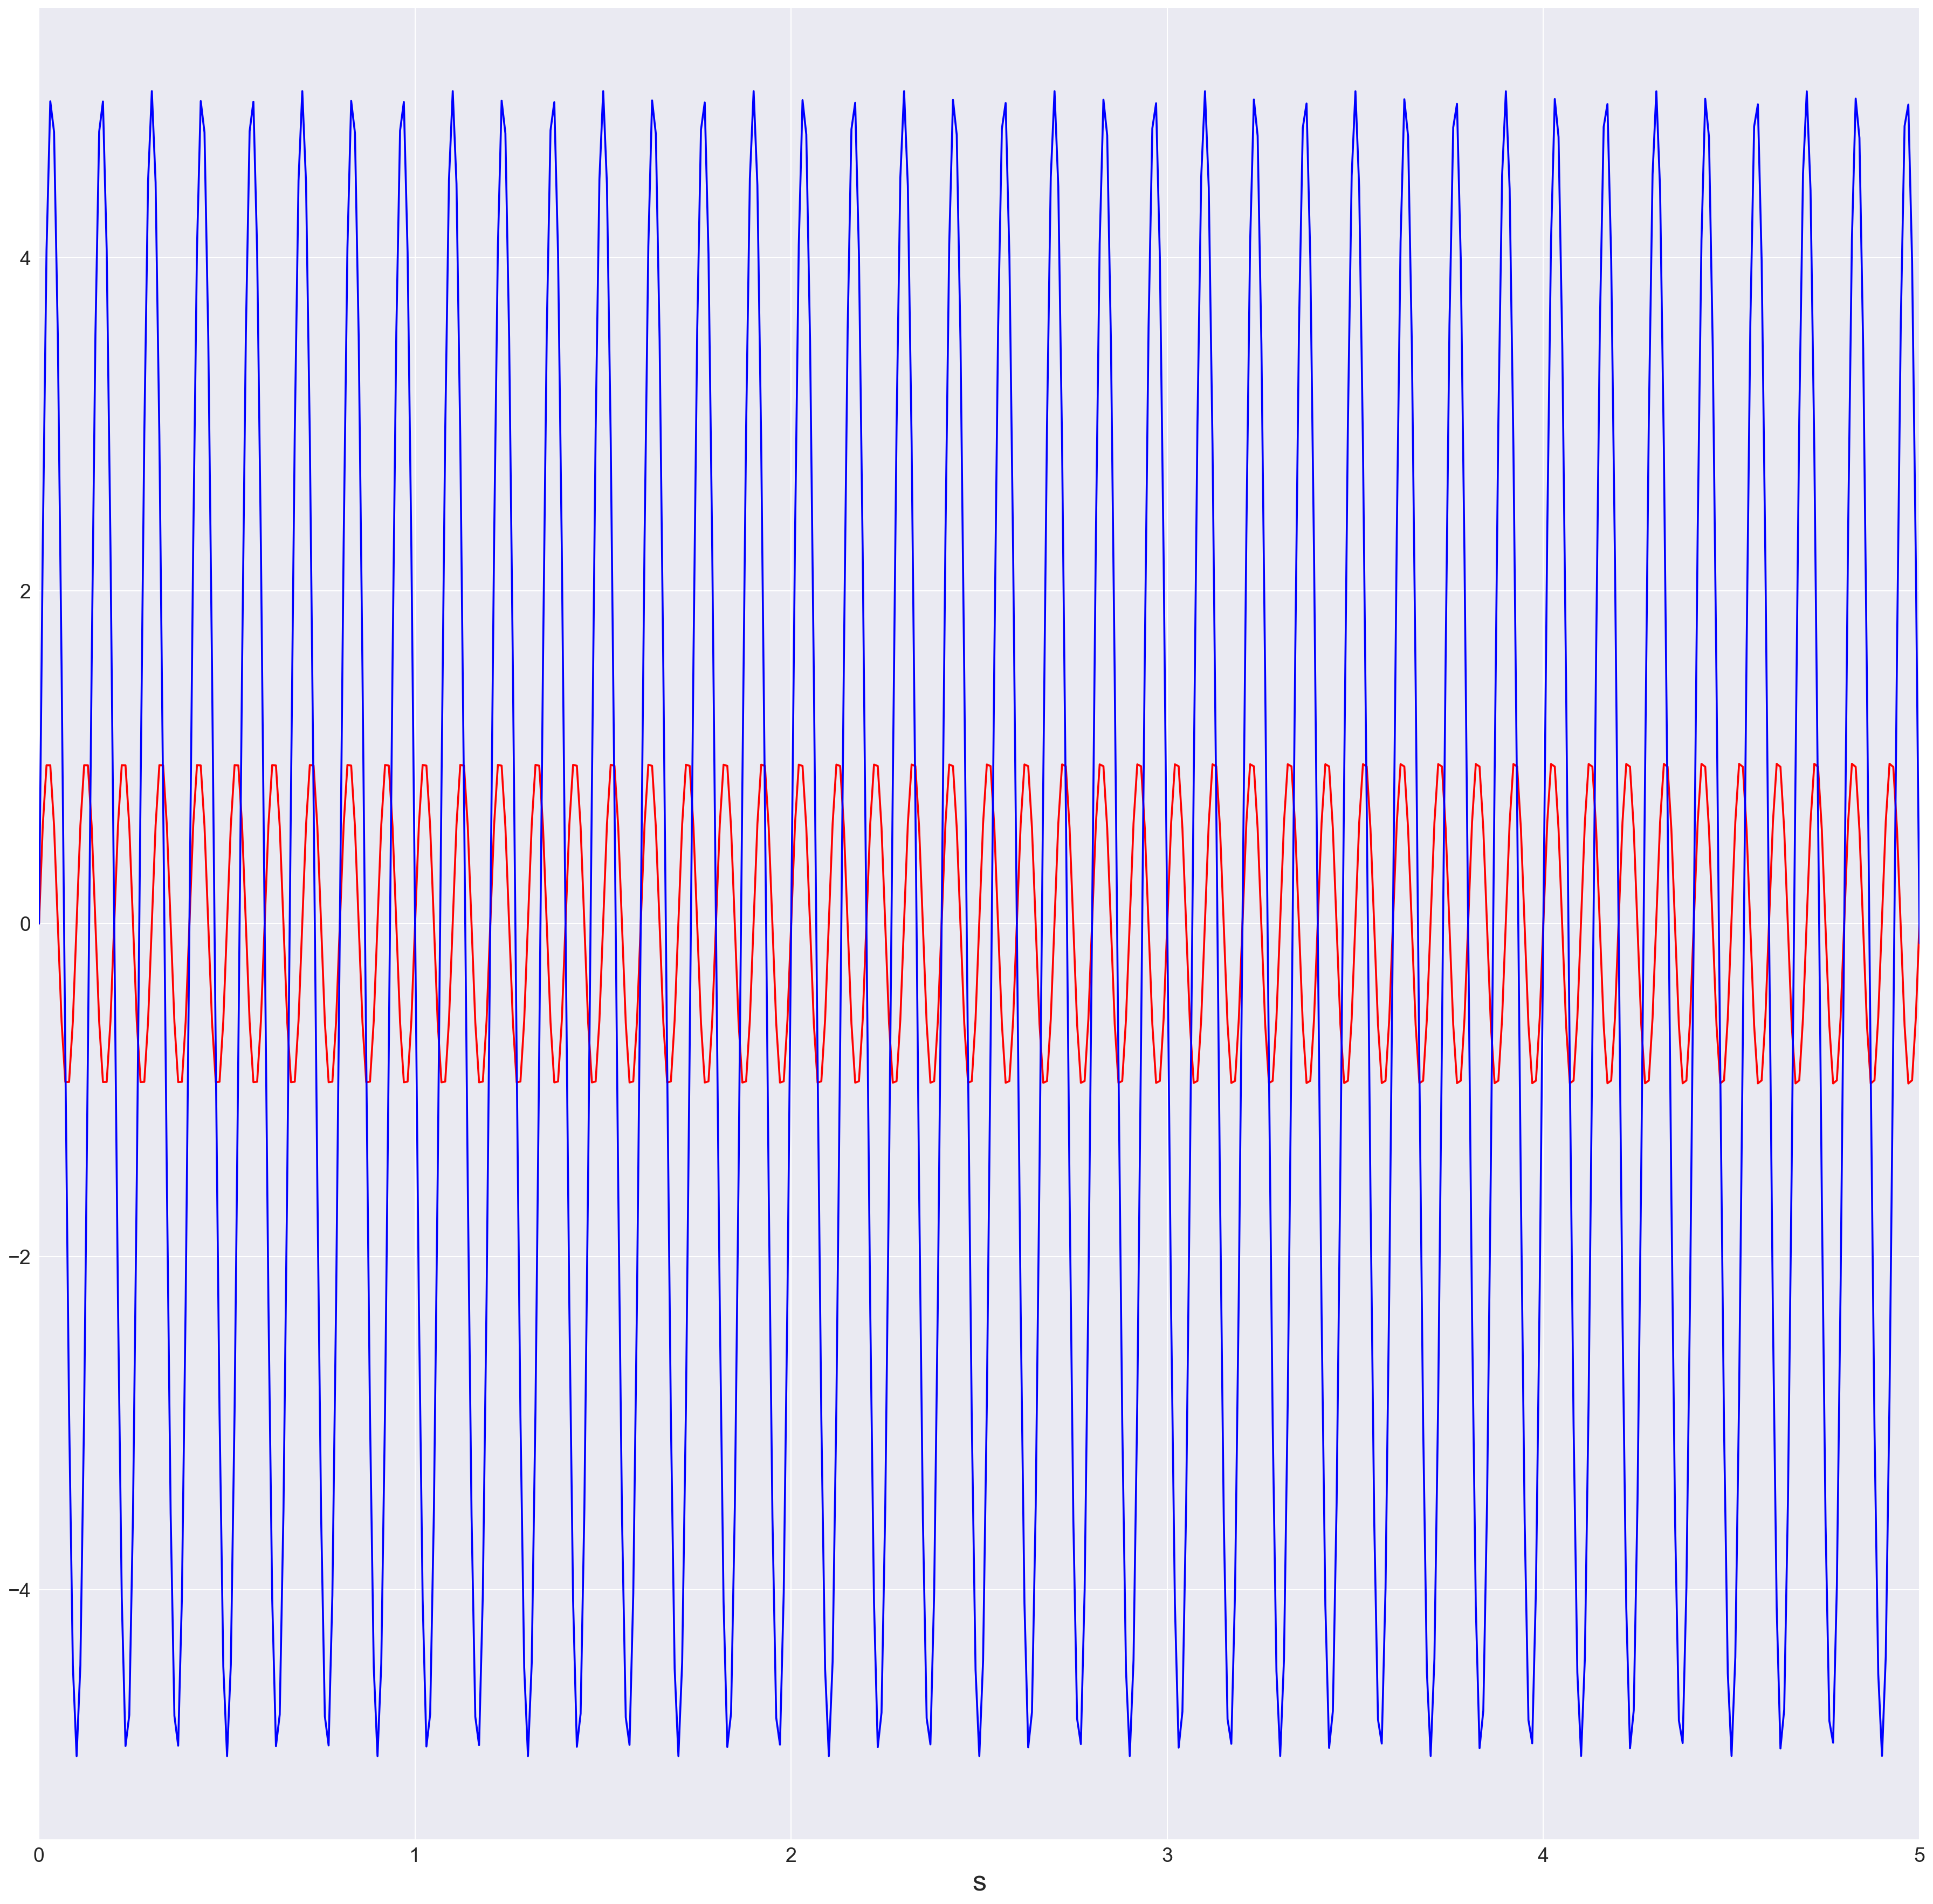

In [6]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r's',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,5))
plt.plot(t,h1,color='red')
plt.plot(t,h2,color='blue')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()


In [7]:
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
h1f=fft.fft(h1)
h1f1=abs(h1f)
hfabs=2.0/Ng*h1f1[0:Ng//2]

h2f=fft.fft(h2)
h2f2=abs(h2f)
hfabs2=2.0/Ng*h2f2[0:Ng//2]
#angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
#s=sci_interpolate.interp1d(xs,hfgas2)
#anglegas=sci_interpolate.interp1d(xs,hfgas_angle)

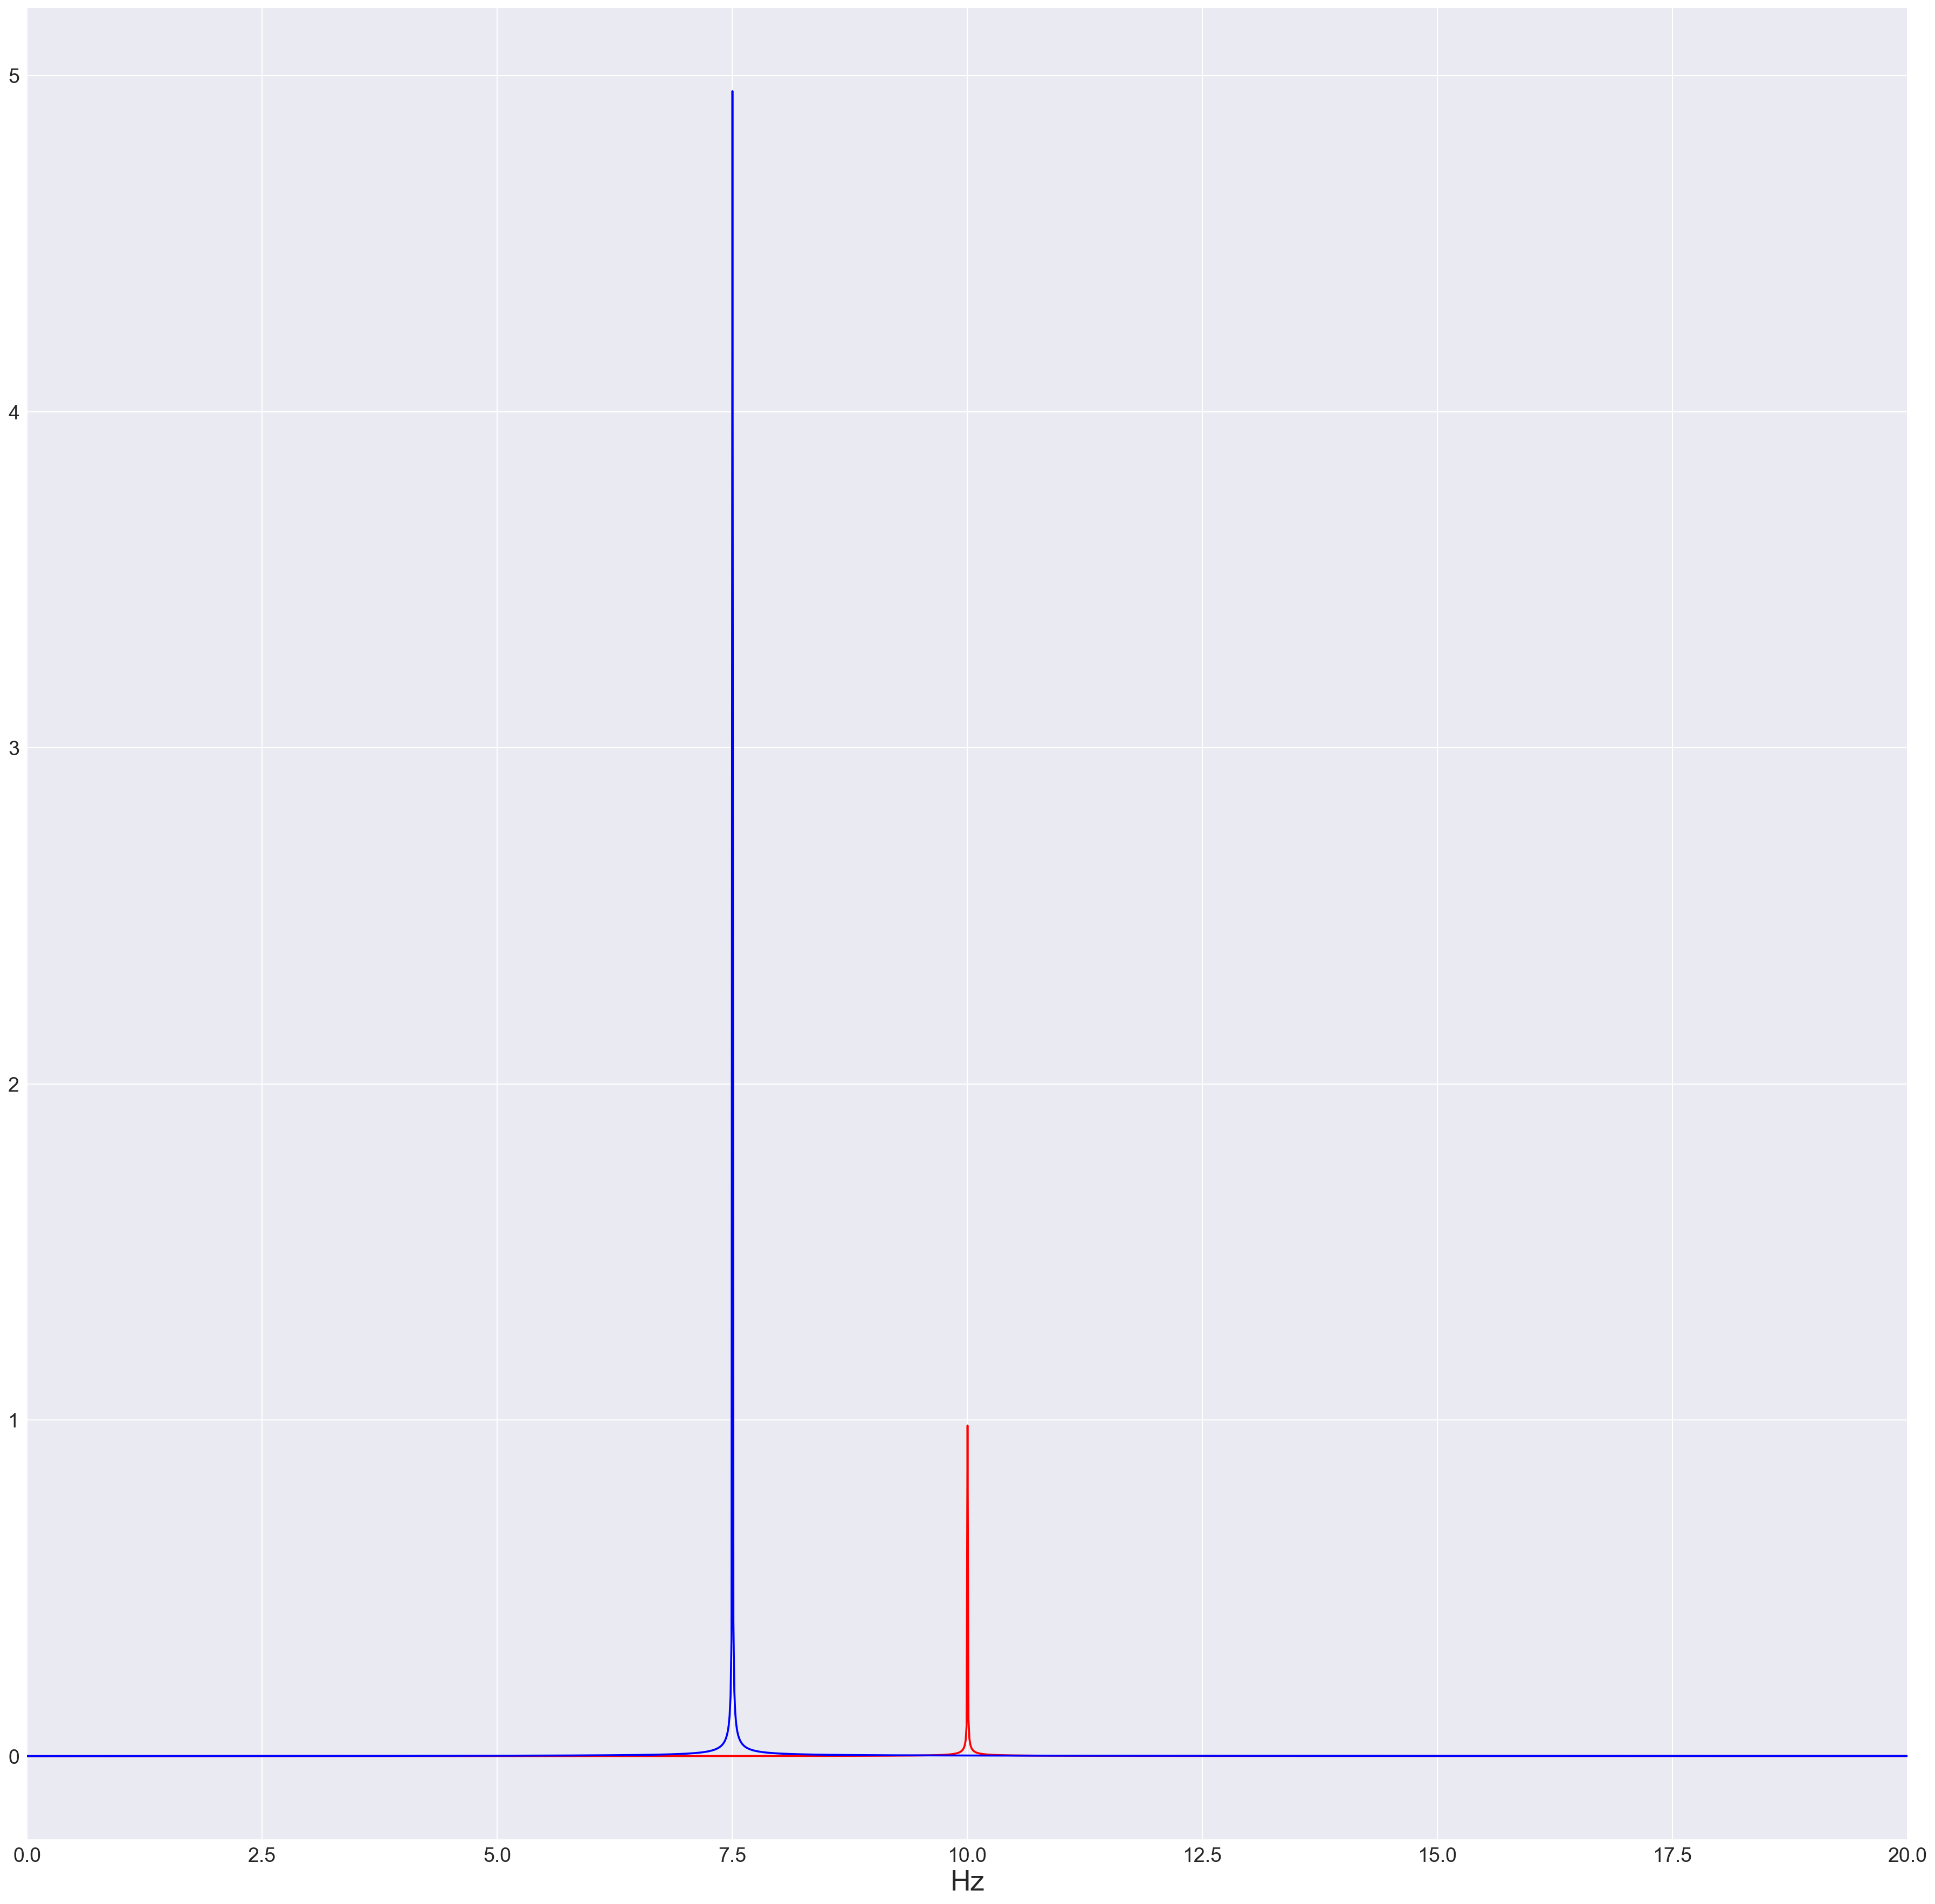

In [8]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,20))
plt.plot(xs,hfabs,color='red')
plt.plot(xs,hfabs2,color='blue')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()


In [9]:
#非pingwen 

In [10]:
Ng=10000000
t_scale=10000.0 
Tg=t_scale/Ng
t=np.linspace(0,t_scale,Ng)
h1=np.sin((20*sciconsts.pi+0.01*t)*t)

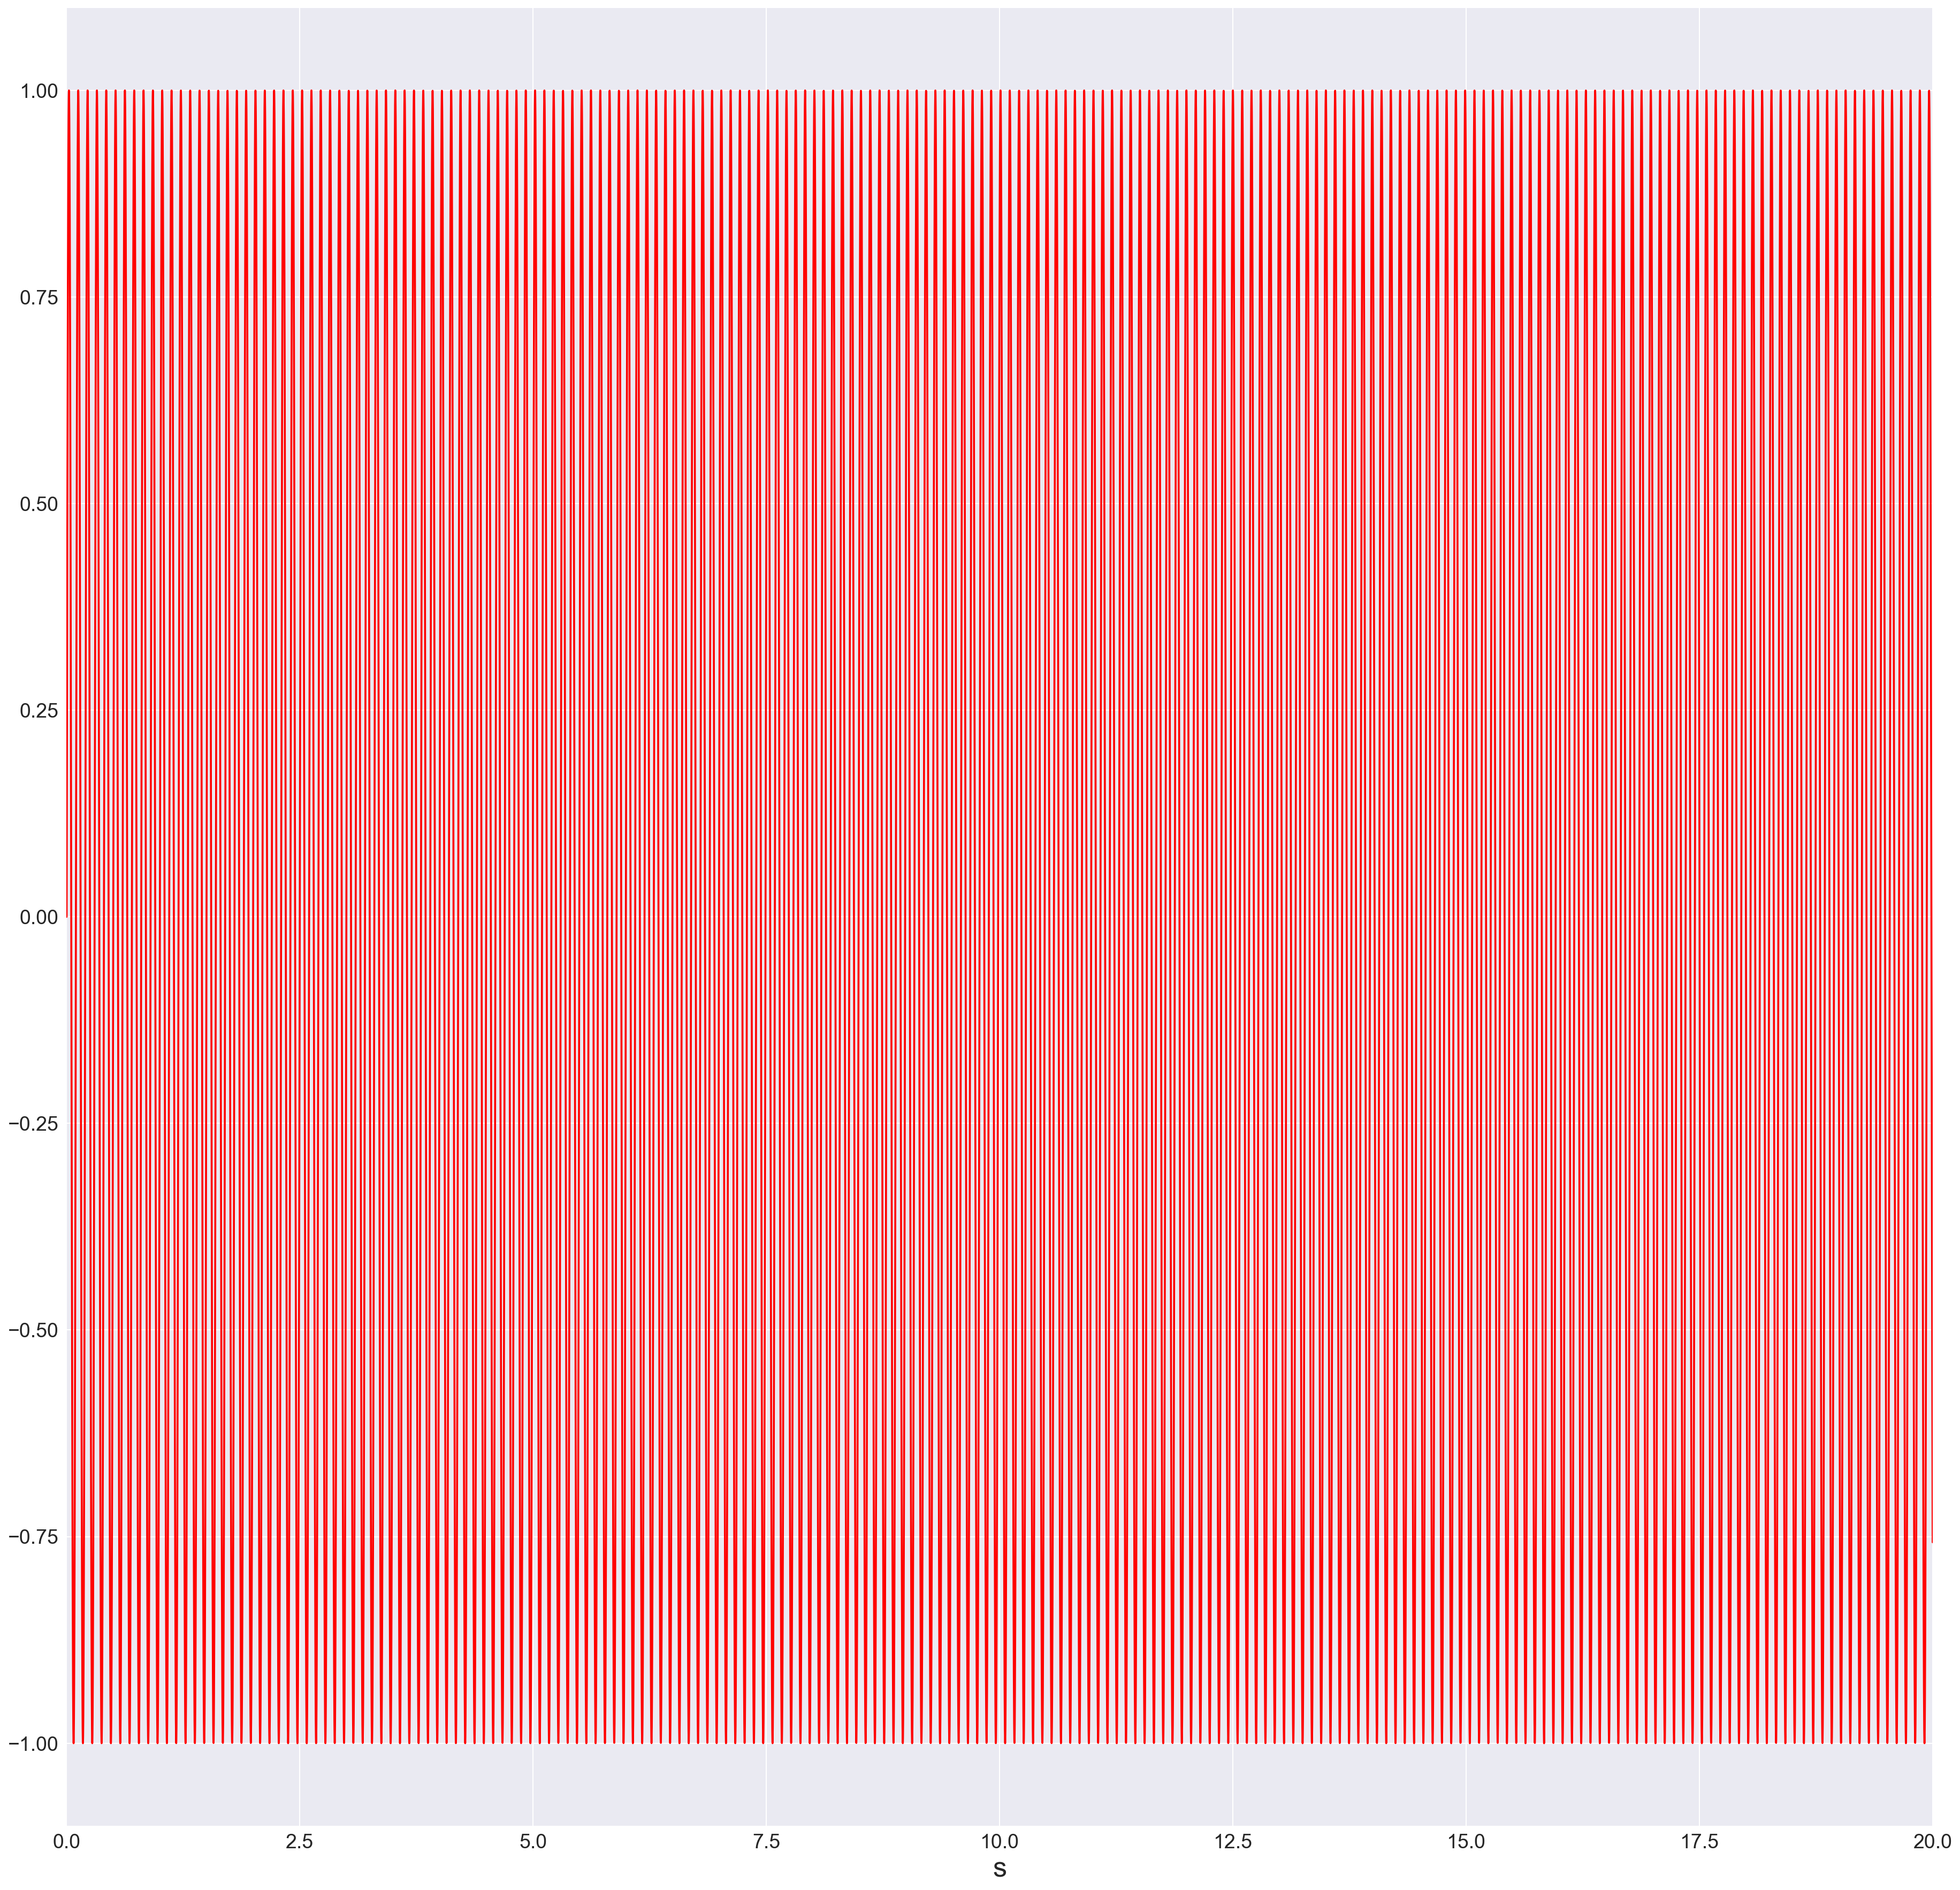

In [11]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r's',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,20))
plt.plot(t,h1,color='red')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()

In [12]:
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
h1f=fft.fft(h1)
h1f1=abs(h1f)
hfabs=2.0/Ng*h1f1[0:Ng//2]

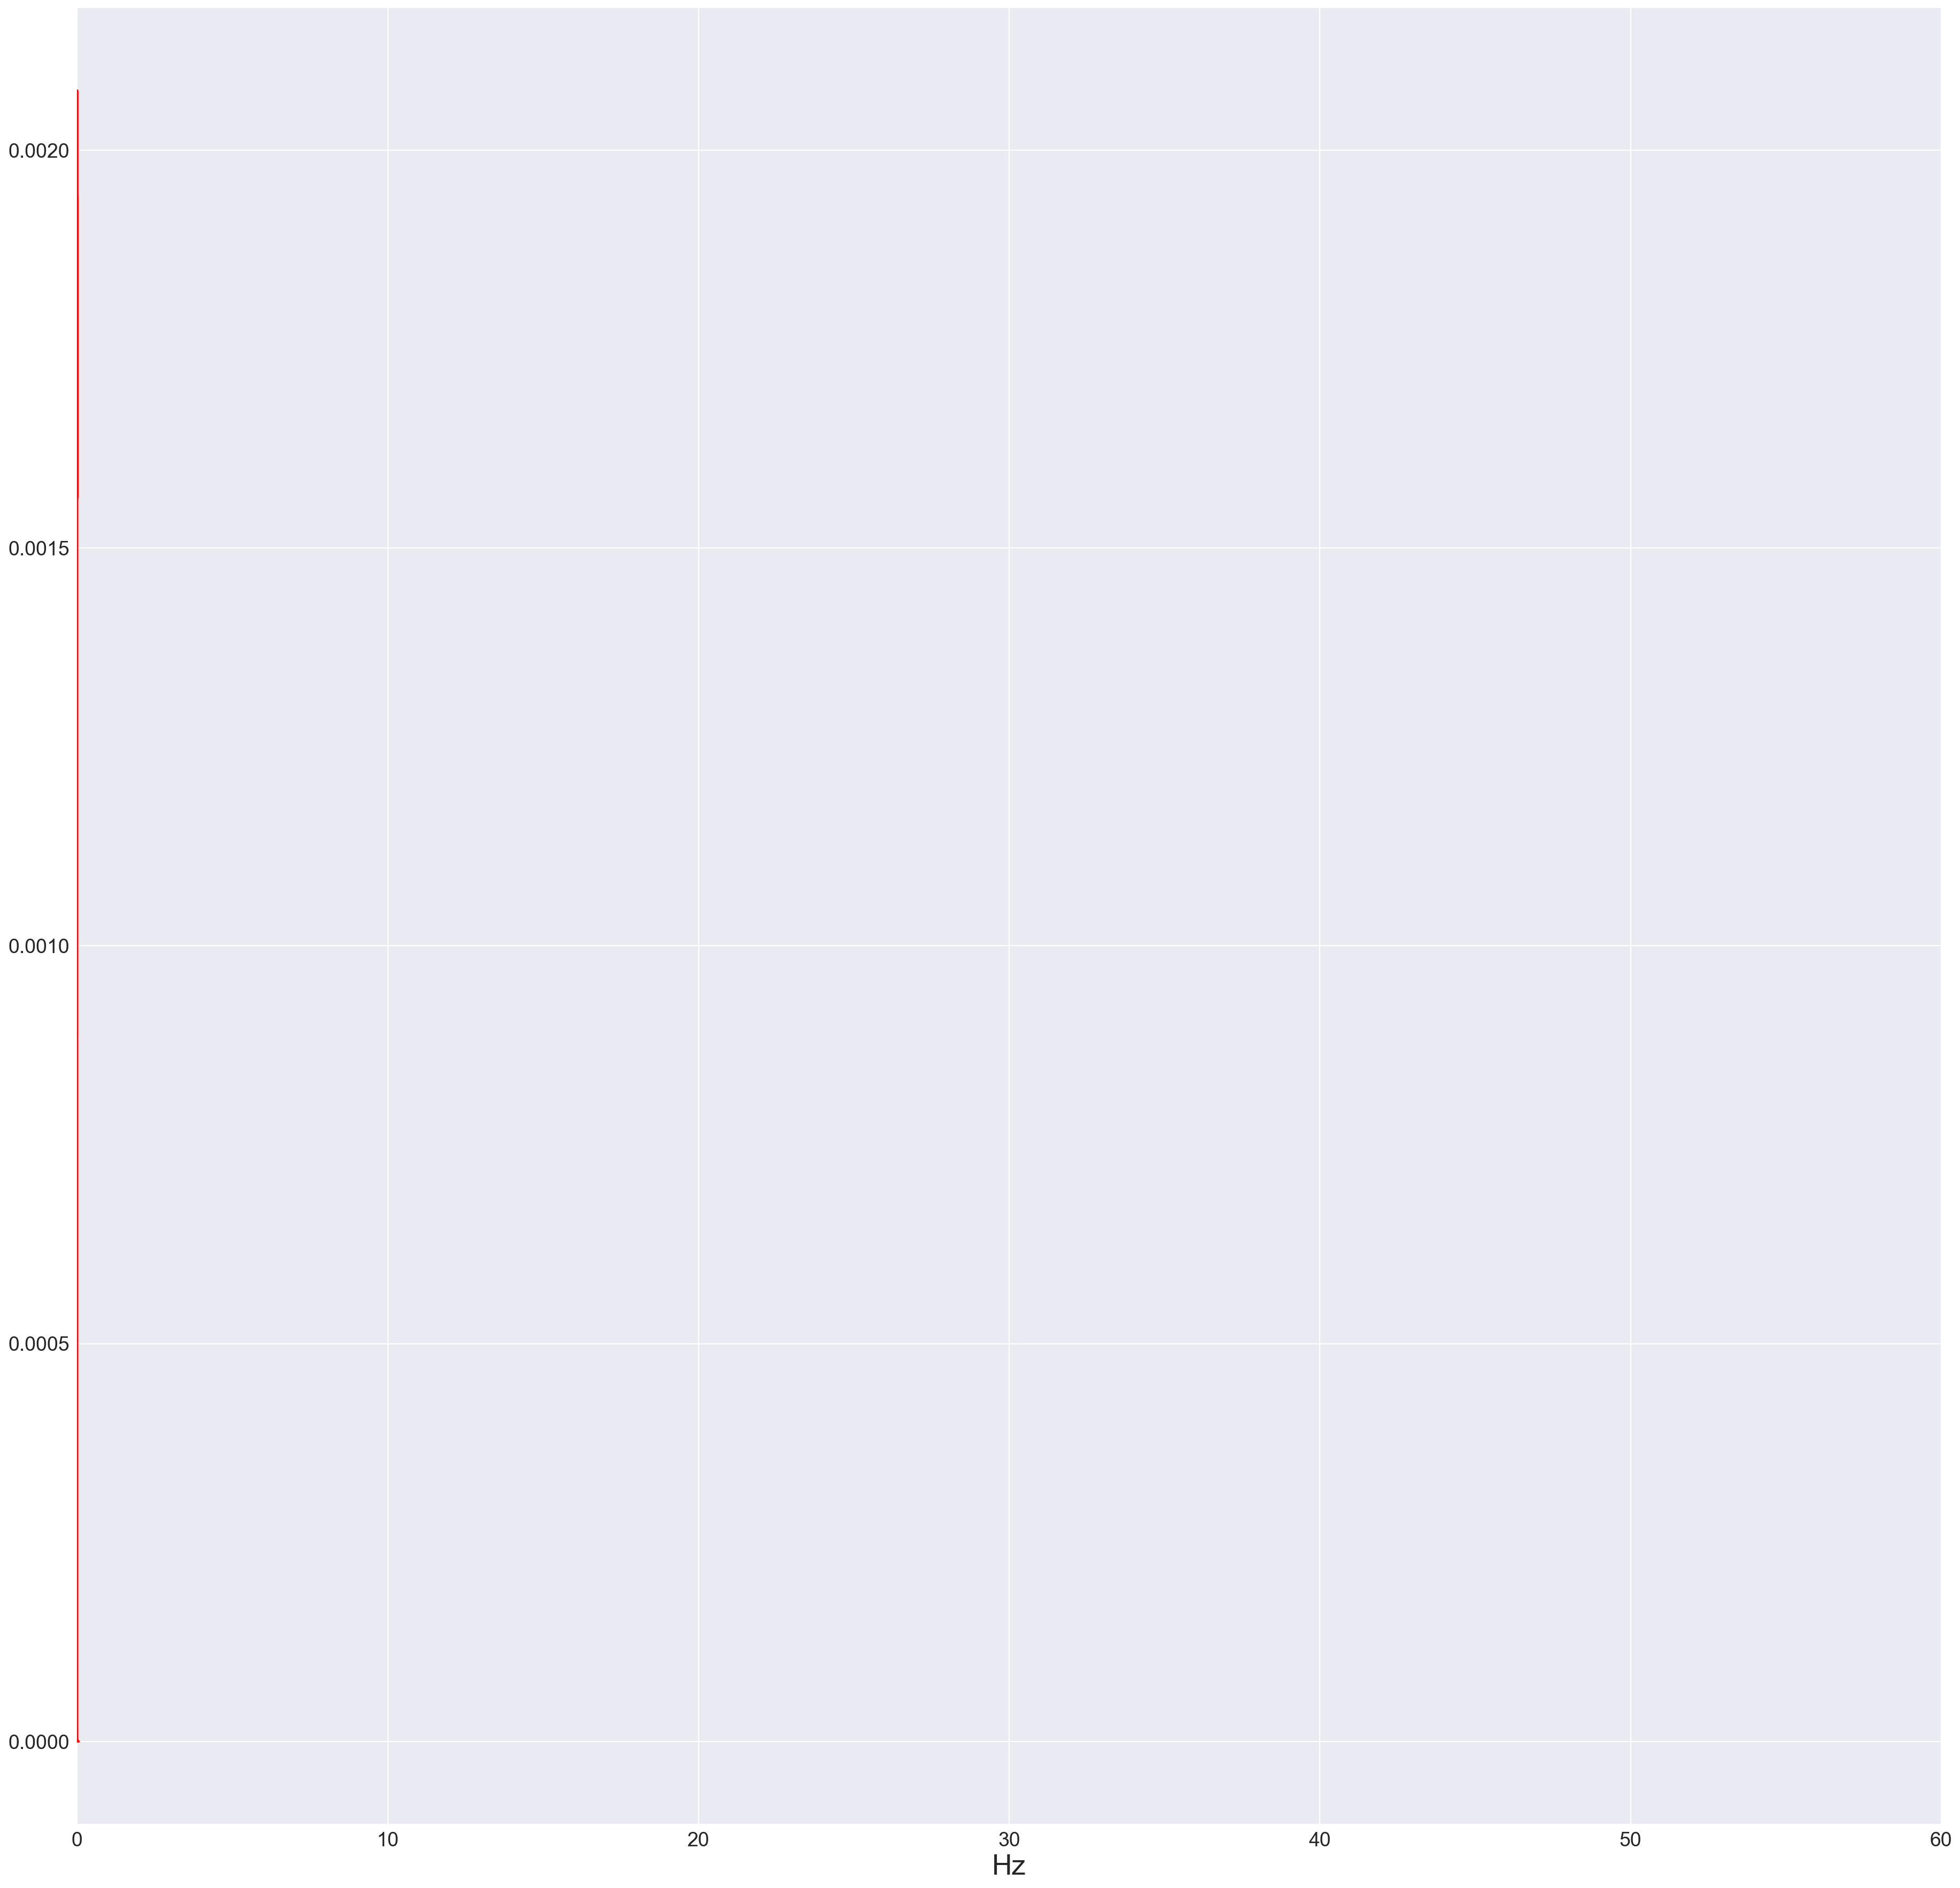

In [33]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,60))
plt.plot(xs,hfabs,color='red')
plt.show()

In [14]:
#gas signal

In [15]:


# In[75]:

#consts setting
sivalue=0.125
m_sun=1.9891e30
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=4*years*sivalue


# In[37]:

#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)
print t_0g/years


13499.2403702


In [16]:

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)

print figas,ffgas

0.00318661208785 0.00318923942835


In [17]:
m1v=36.74*m_sun*sciconsts.G/np.power(sciconsts.c,3.0)
m2v=m1v
print m1v

0.000181019378162


In [18]:
def phi_v(t,m1,m2,tc):
    cm=chirp_mass(m1,m2)
    return -2.0*np.power(0.2*(tc-t)/cm,5.0/8.0)

In [64]:
def r_v(t,m1,m2,tc):
    return np.power(256.0/5.0*(m1*m2*(m1+m2))*(tc-t),0.25)
def h_v(t,m1,m2,tc):
    phi_0=phi_v(0,m1,m2,tc)
    return np.power(384/5,0.5)*np.power(sciconsts.pi,2.0/3.0)*m1*m2/r_v(t,m1,m2,tc)*np.cos(phi_v(t,m1,m2,tc)-phi_0)

In [20]:
tc=5.0*np.power(8*sciconsts.pi*figas,-8.0/3.0)*np.power(chirp_mass(m1v,m2v),-5.0/3.0)

In [21]:
tc/years

289.36597121628034

In [22]:
h=h_v(t,m1v,m2v,tc)

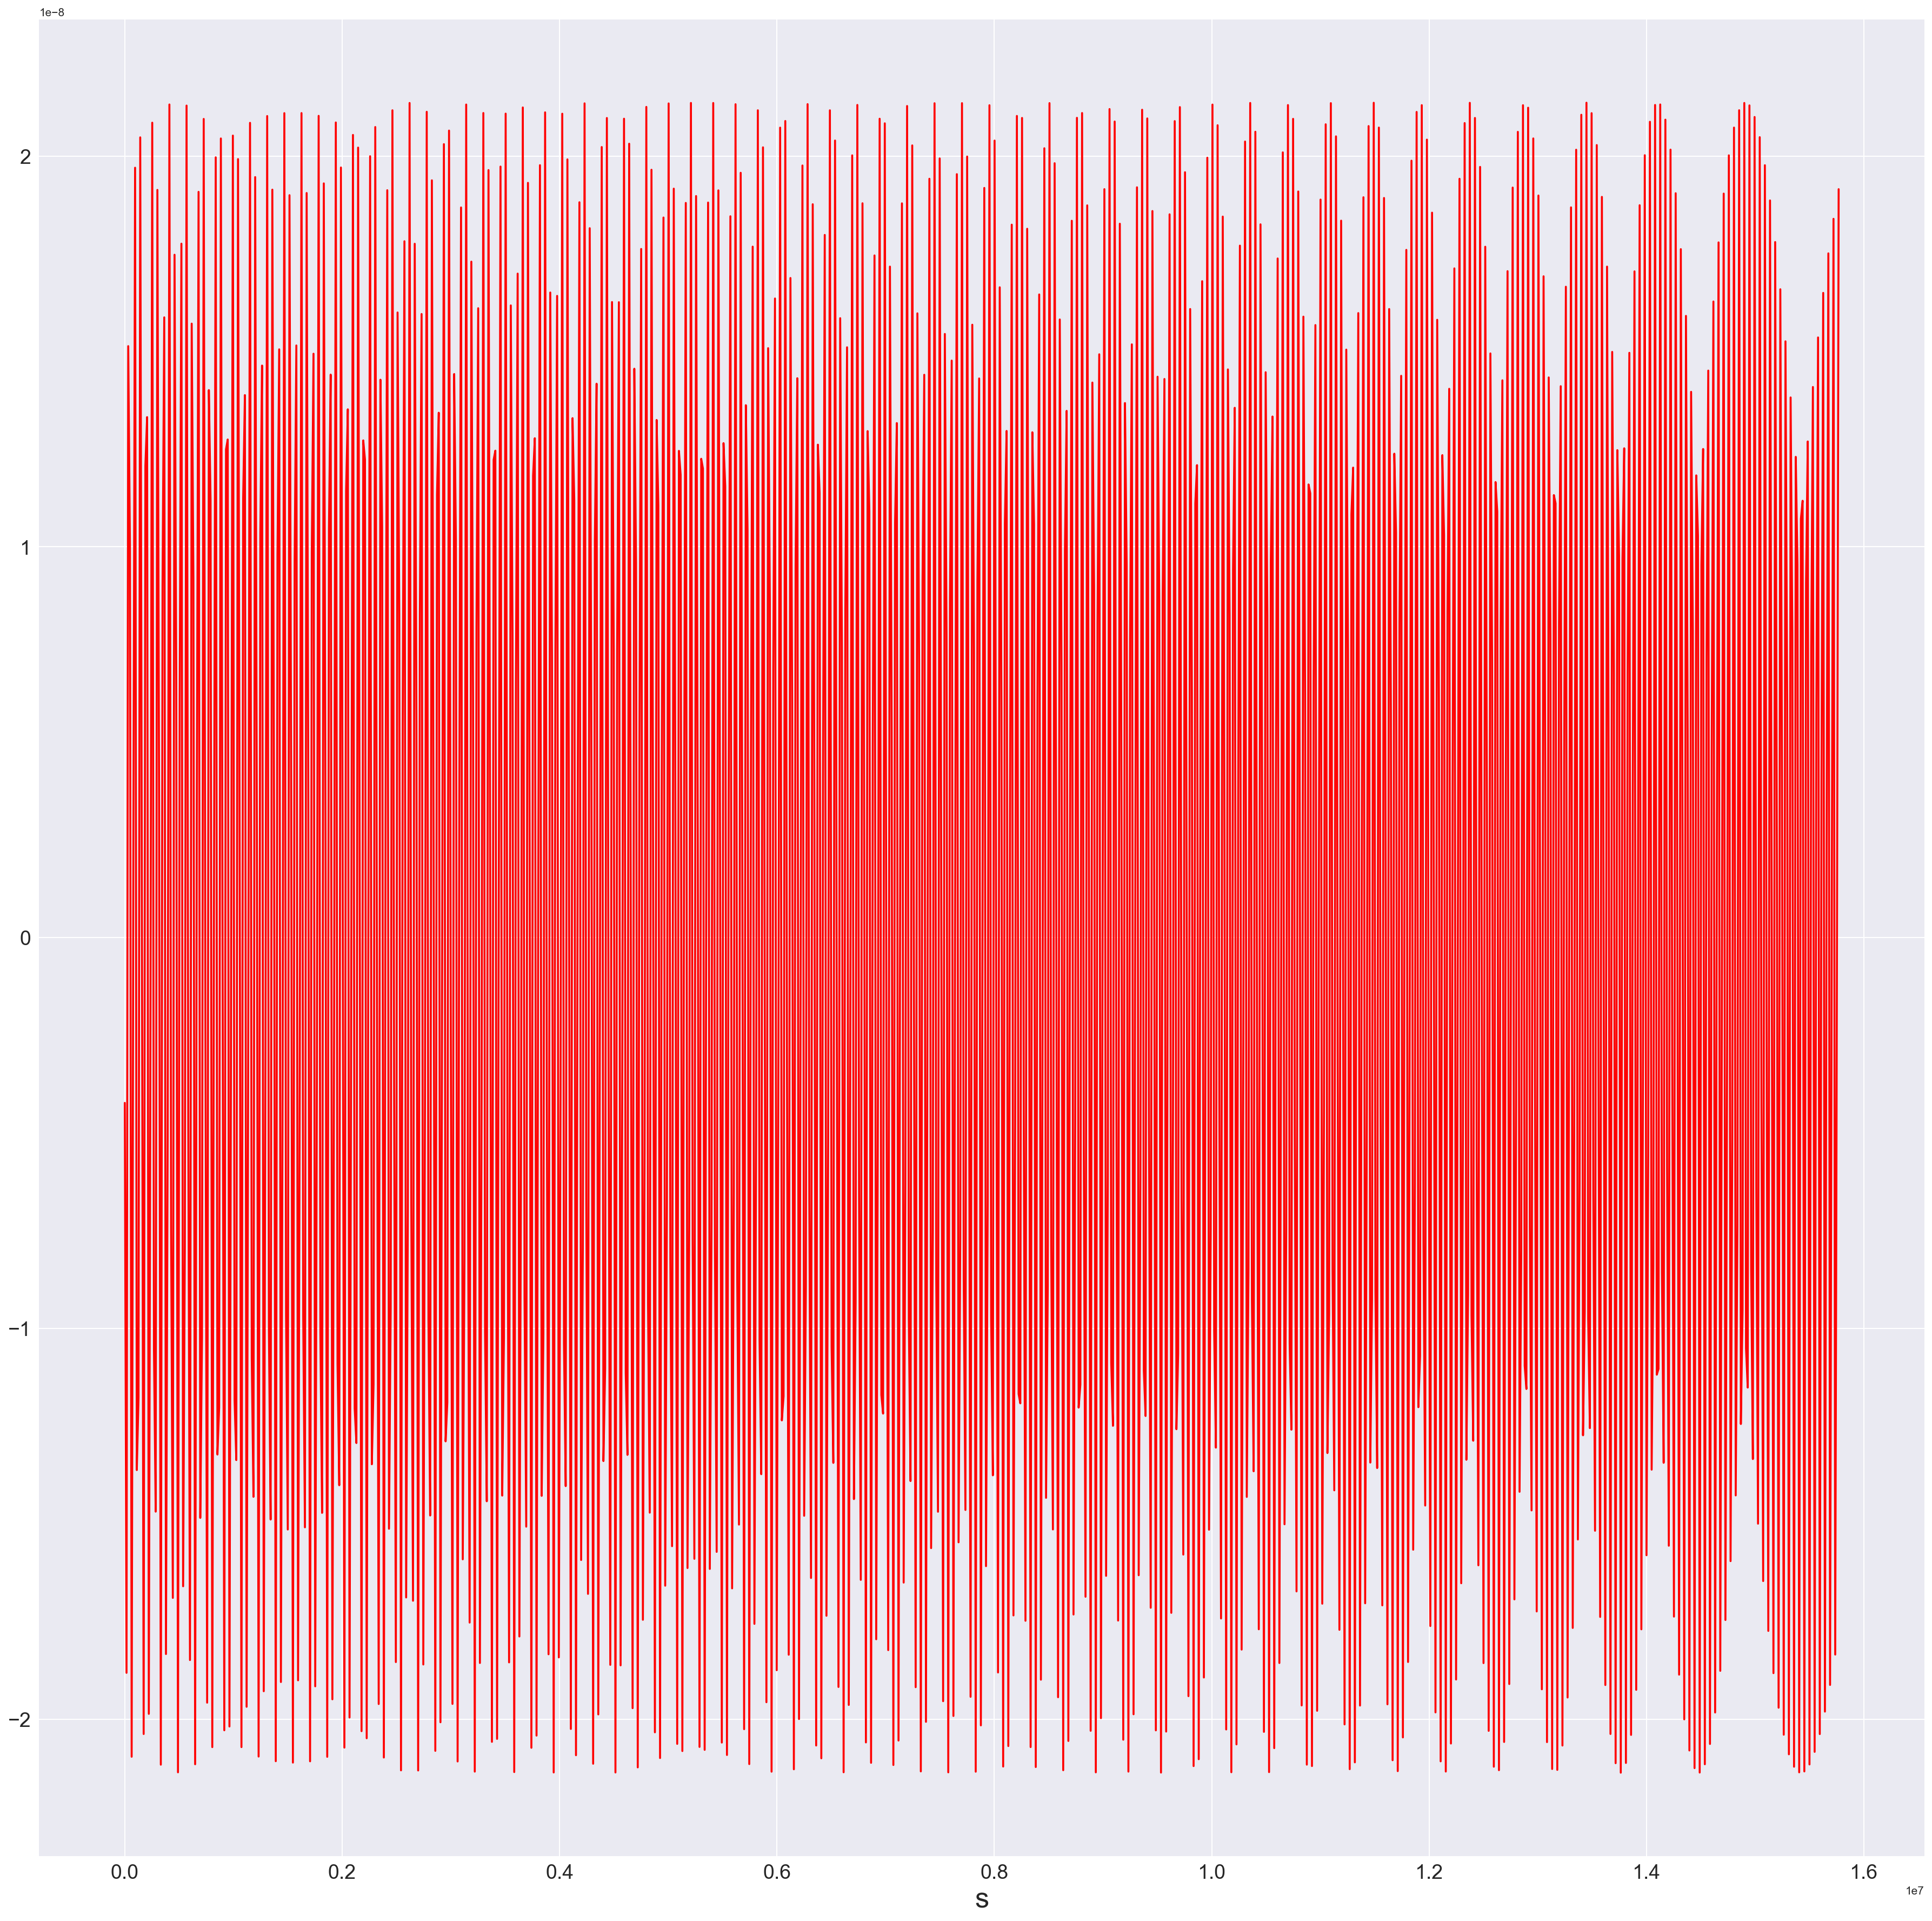

In [23]:
fig1=plt.figure(figsize=(30,30),dpi=150)
td=np.linspace(0,t_scale,1000)
hdraw=h_v(td,m1v,m2v,tc)
#matplotlib.rcParams['agg.path.chunksize'] = 10000
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r's',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(td,hdraw,color='red')
#plt.plot(xse,he,color='blue')
plt.show()

In [24]:
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(h)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hvac=sci_interpolate.interp1d(xs,hfvac2)
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)

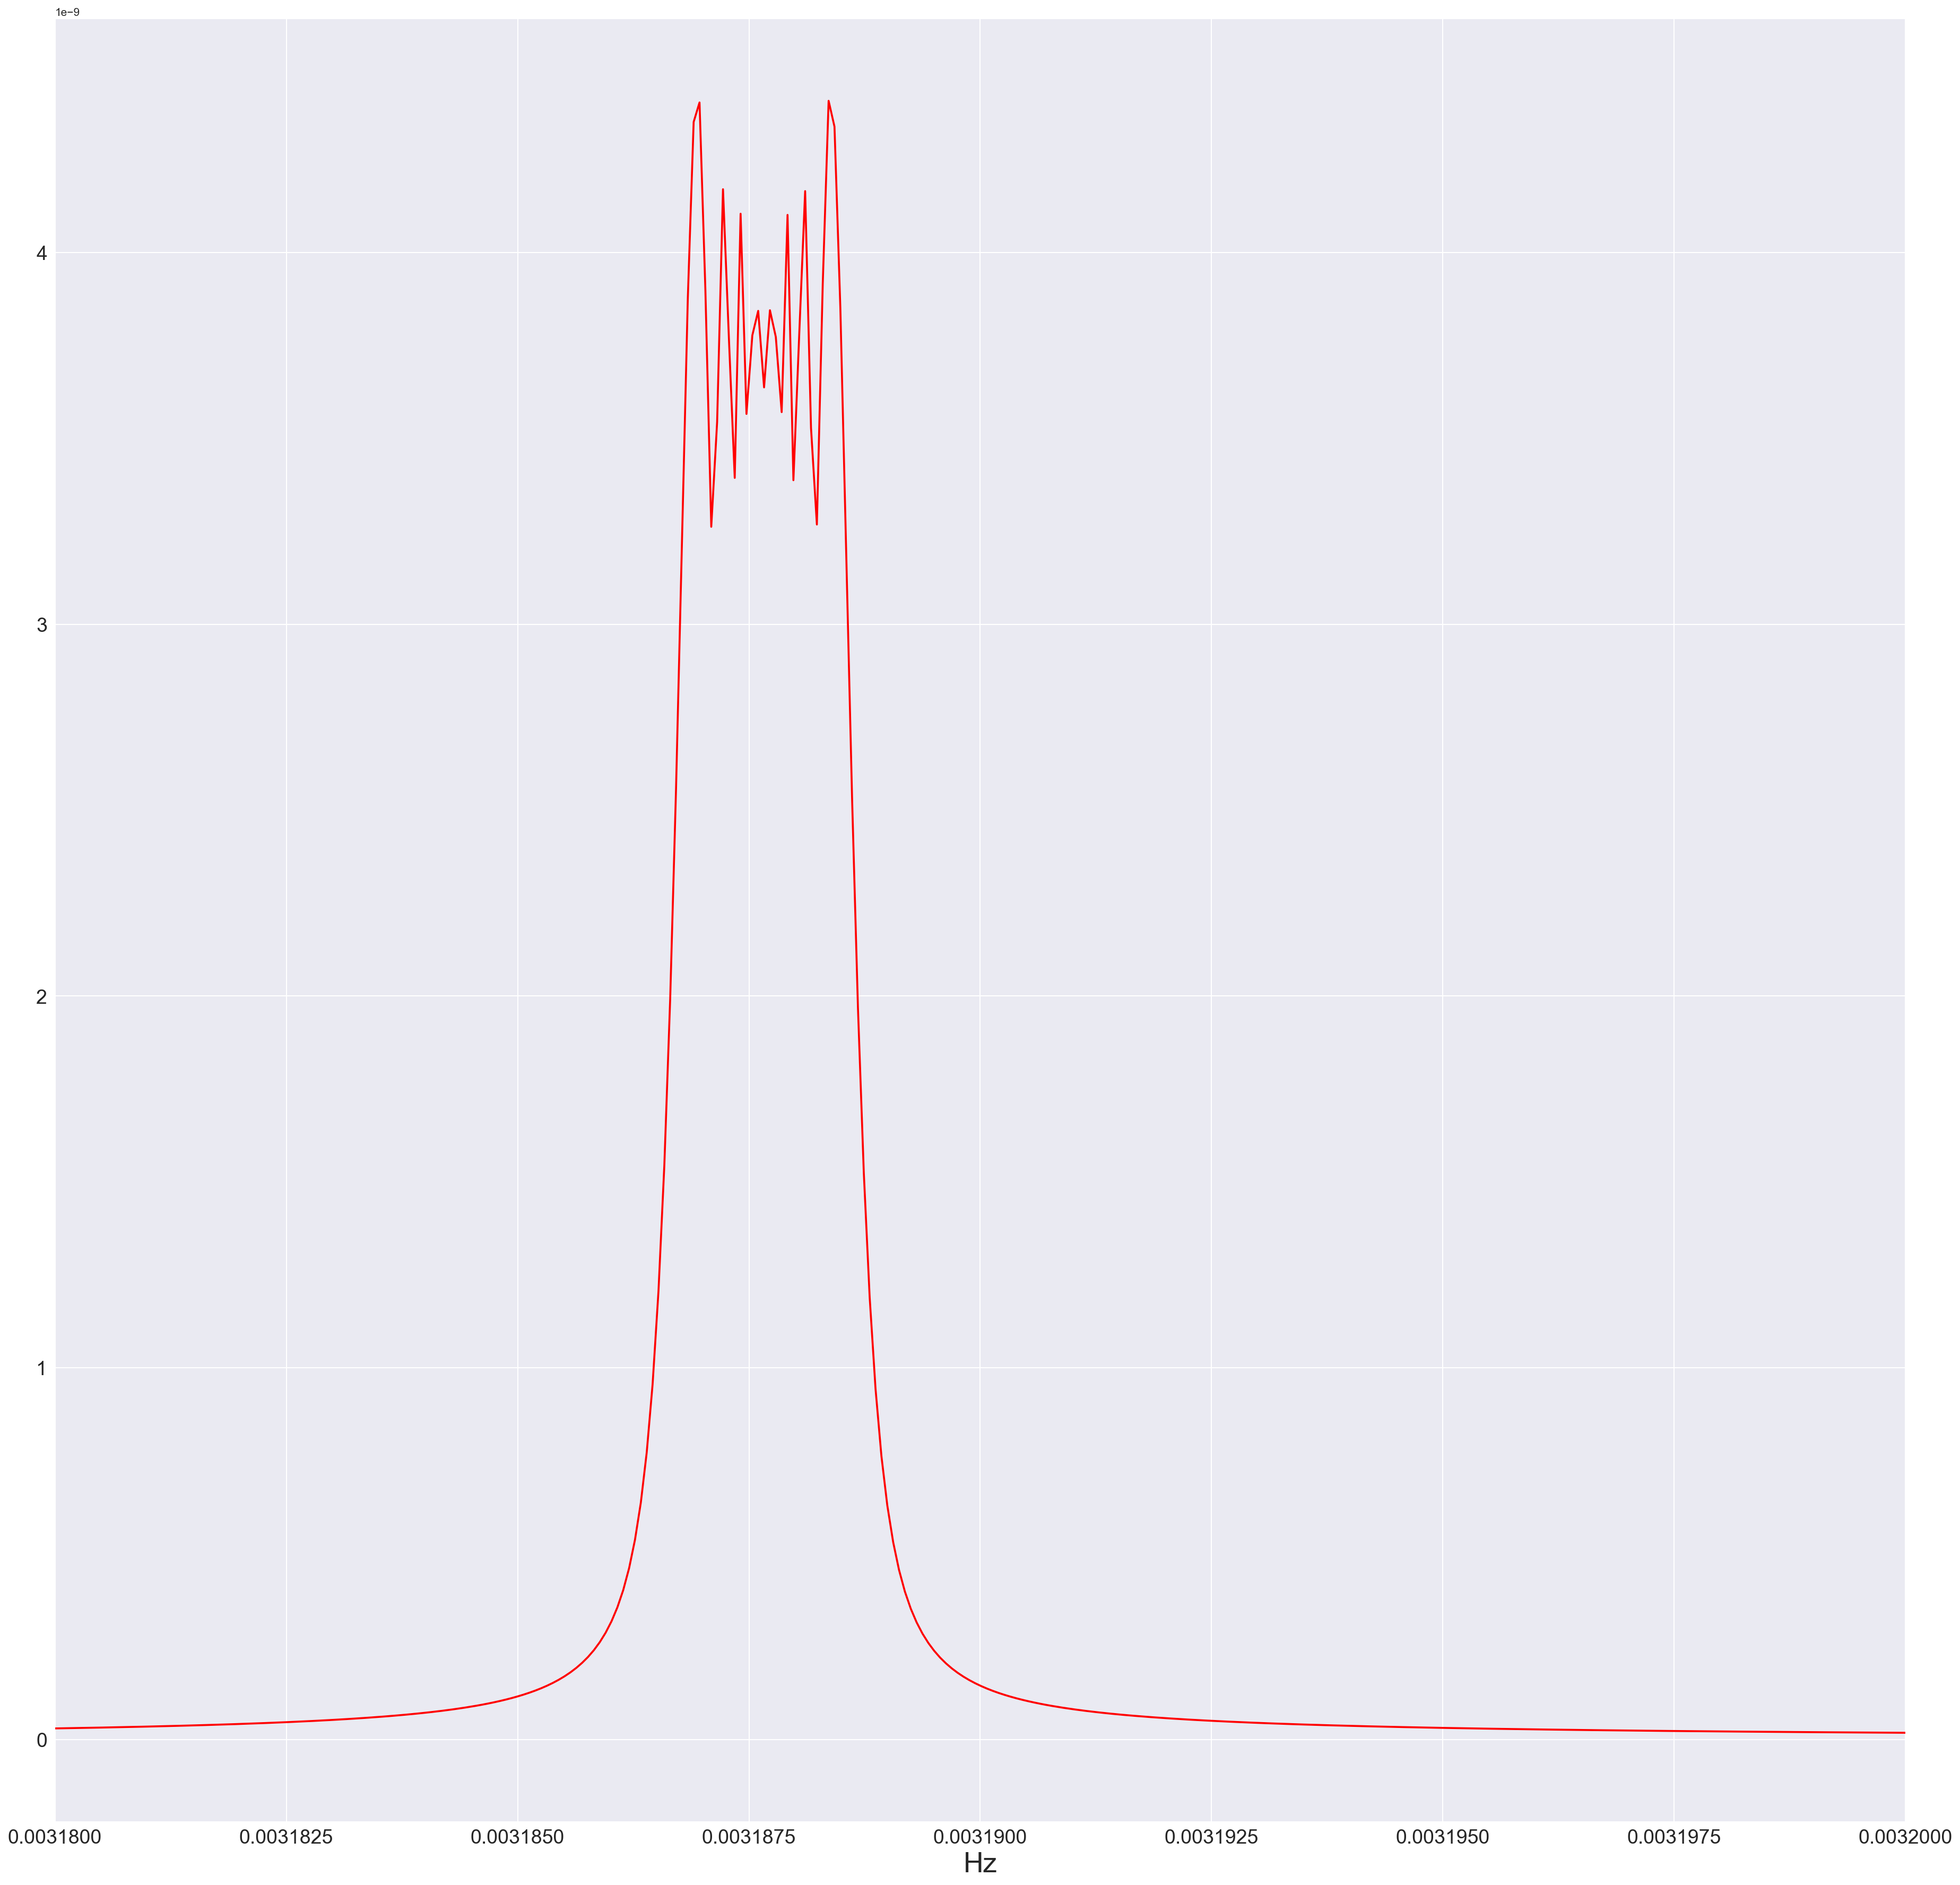

In [25]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0.00318,0.0032))
#plt.ylim((0,1e-9))
plt.plot(xs[0:Ng//2],hfvac2,color='red')
#plt.plot(xse,he,color='blue')
plt.show()

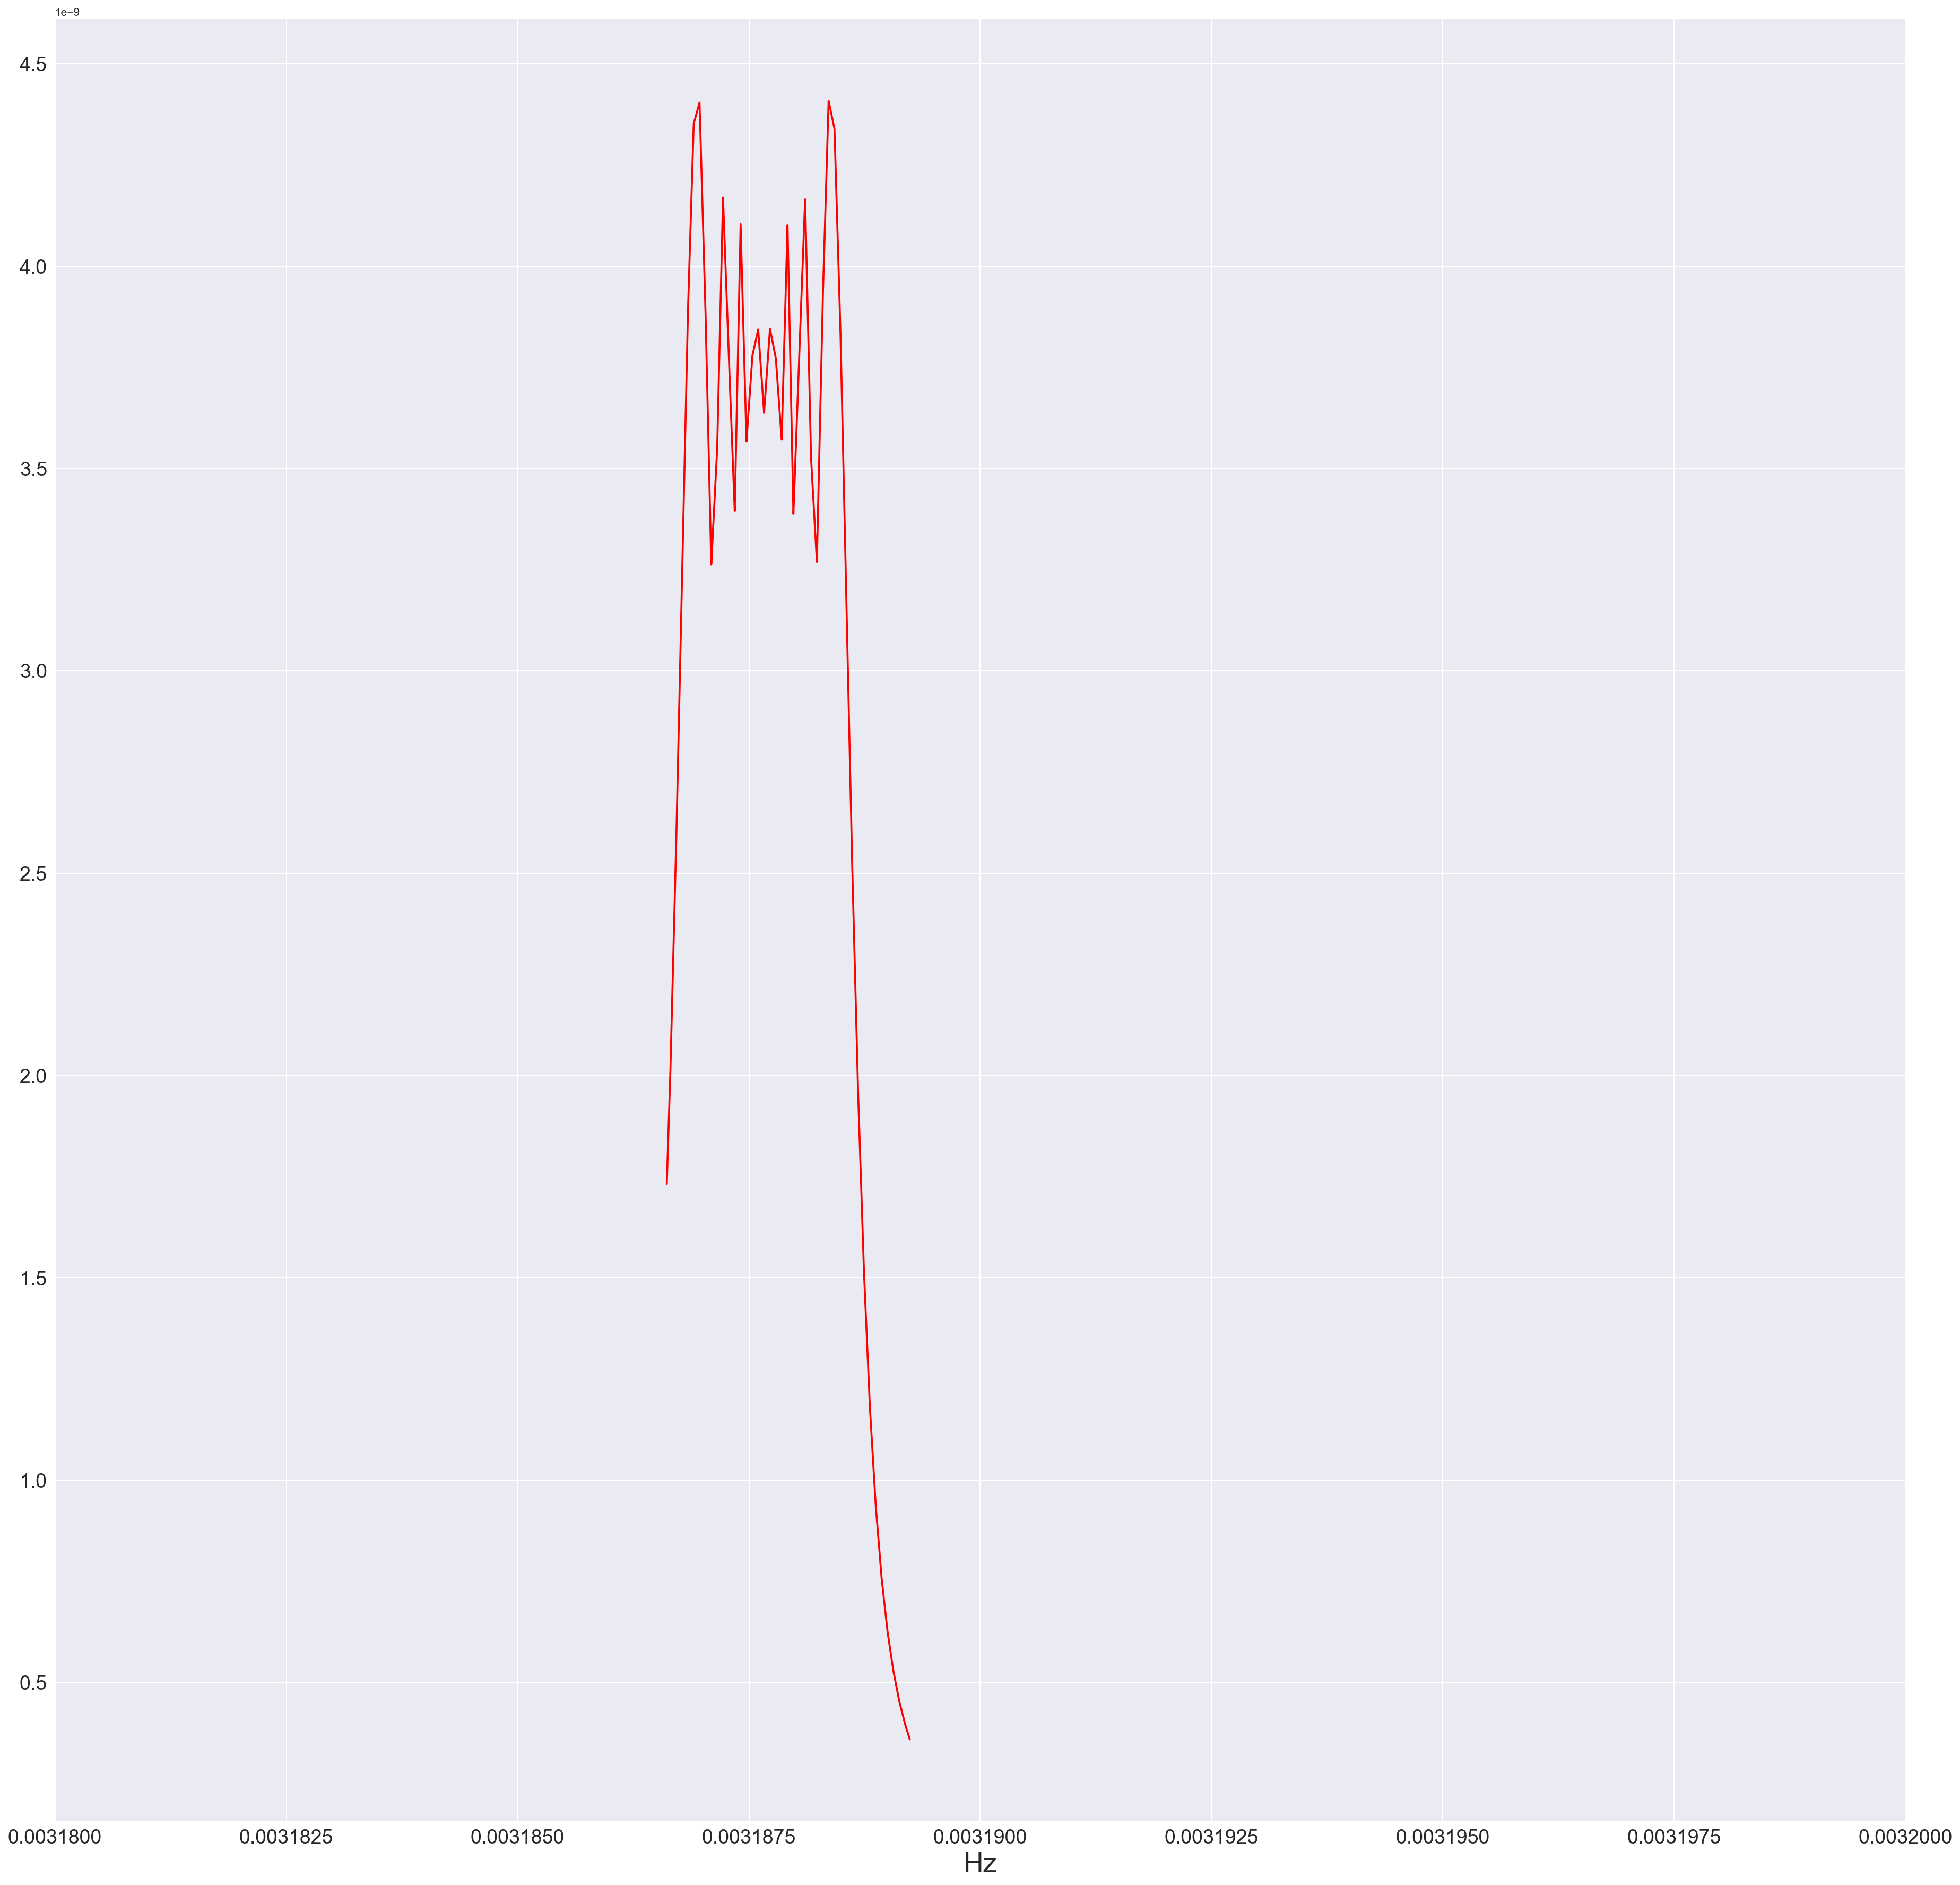

In [26]:
xse=np.linspace(figas,ffgas,10000)
he=np.power(chirp_mass(m1v,m2v),5.0/6.0)*np.power(xse,-7.0/6.0)
hv=hvac(xse)
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0.00318,0.0032))
#plt.ylim((0,1e-9))
plt.plot(xse,hv,color='red')
#plt.plot(xse,he,color='blue')
plt.show()

In [27]:
he

array([ 0.55468764,  0.55468759,  0.55468754, ...,  0.55415467,
        0.55415461,  0.55415456])

In [28]:
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [29]:
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [120]:
Ng=int(50000000)
t_scale=20*years
t=np.linspace(0,t_scale,num=Ng)
Tg=t_scale/Ng
h=h_v(t,m1v,m2v,289.36597121628034*years)
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(h)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hfvac2=Tg*hfvac_abs[0:Ng//2]
hvac=sci_interpolate.interp1d(xs,hfvac2)
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)

In [121]:
xse=np.linspace(1e-4,2e-2,10000)
he=np.power(chirp_mass(m1v,m2v),5.0/6.0)*np.power(xse,-7.0/6.0)

In [122]:
hfvac2=hfvac2/mpc
he=he/mpc

In [145]:
h=np.zeros(10000)
for i in range(0,10000):
    h[i]=np.sqrt(S_n_lisa(xse[i]))

In [151]:
fig1=plt.figure(figsize=(30,30),dpi=500)
#plt.ylabel('FF',fontsize=25)
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.title(r'$t=20year$ $t_c=283year$ D=1mpc',fontsize=25)
plt.xlabel(r'f[Hz]',fontsize=25)
plt.ylabel(r'h(f)',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0.001,0.004))
plt.yscale('log')
plt.xscale('log')

line1,=plt.plot(xs[0:Ng//2],hfvac2,color='red')
line2,=plt.plot(xse,he,color='blue')
line3,=plt.plot(xse,h,color='black')
plt.legend([line1,line2,line3],['numerical','analytic',r'$\sqrt{S_n(f)}$'],loc=3,fontsize=50,frameon=True)
plt.show()

In [100]:
np.power(chirp_mass(m1v,m2v),5.0/6.0)*np.power(figas/2+ffgas/2,-7.0/6.0)/hvac(figas/2+ffgas/2)/(t_scale/2)

0.9949719015051508

In [32]:
hfvac2.max()

8.7807529119647521e-11

array([  5.88928981e-16 +0.00000000e+00j,
         5.88928982e-16 +1.05163998e-20j,
         5.88928983e-16 +2.10318378e-20j, ...,
         5.88928984e-16 -3.15477688e-20j,
         5.88928983e-16 -2.10318378e-20j,   5.88928982e-16 -1.05163998e-20j])

In [63]:
sciconsts.G

6.67408e-11

In [66]:
m1v/36.74

4.9270380555784719e-06

In [79]:
m2v/36.74

4.9270380555784719e-06

In [80]:
years

31536000.0

In [83]:
t_scale/2

31536000.0

In [106]:
mpc

3.0851442071085988e+16

In [128]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Places a legend on the axes.
    
    To make a legend for lines which already exist on the axes
    (via plot for instance), simply call this function with an iterable
    of strings, one for each legend item. For example::
    
        ax.plot([1, 2, 3])
        ax.legend(['A simple line'])
    
    However, in order to keep the "label" and the legend element
    instance together, it is preferable to specify the label either at
    artist creation, or by calling the
    :meth:`~matplotlib.artist.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        # Overwrite the label by calling the method.
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting with an underscore.
    This is default for all artists, so calling :meth:`leg

In [138]:
h=[]

In [139]:
h,=[1]

AttributeError: 'int' object has no attribute 'type'

In [144]:
xs

array([  0.00000000e+00,   1.58548966e-09,   3.17097933e-09, ...,
         3.96372368e-02,   3.96372384e-02,   3.96372400e-02])